In [35]:
import pandas as pd 
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot 

# Idea: Can we predict if an athlete will win a medal?

This is an ambitious prediction goal, after all the data at hand is very limited. In the real world teams of people and machines attempt to answer this question. However, I will have a crack at it below 'for sport'! 

Thinking carefully about features, some certainly carry important information, while others are redundant.<br>
- Features to keep : Sex, Age, Height, Weight, Season, Sport.
- Features to drop: ID, Name, Team, NOC, Games, Year, City, Event.
- Target: Medal or No_Medal? Make into binary classification to reduce class imbalance

The above feature selection, yields the following question:<br>
Given an athletes body metrics, age, the sport he competes in and the country he represents, can we tell if he/she will win a medal?

#### Initial data wrangling

In [37]:
# Load Clean data 
clean = pd.read_csv('all_data/clean_data.csv')
clean.drop('Unnamed: 0',axis=1,inplace=True)

In [38]:
clean.drop(['ID', 'Name','Team','NOC', 'Games', 'Year','City','Event'] ,axis=1,inplace=True)

In [39]:
clean.isnull().sum()

Sex           0
Age           3
Height     2276
Weight     6202
Season        0
Sport         0
Medal         0
Country       0
dtype: int64

Drop NA values, we know this are points from the distant past where there is no good way to fill the data because of insufficient information. I will drop this points, which constitute 2.5% of the data rows

In [40]:
clean.dropna(inplace=True)

In [41]:
assert(clean.isnull().sum().sum()==0)

In [42]:
# make target
clean.loc[clean.Medal == 'No_Medal','Target']= 0
clean.loc[clean.Medal != 'No_Medal','Target']= 1

In [43]:
print('minority class is about {}% of data'.format(round(100*clean.Target.sum() / clean.shape[0],1))) 

minority class is about 14.3% of data


In [44]:
# clean up target
y = clean.Target
clean.drop(['Medal','Target'],axis=1,inplace=True)

In [45]:
clean.head()

,Sex,Age,Height,Weight,Season,Sport,Country
0,M,24.0,180.000000,80.000000,Summer,Basketball,China
1,M,23.0,170.000000,60.000000,Summer,Judo,China
2,M,24.0,174.916667,75.181818,Summer,Football,Denmark
4,F,21.0,185.000000,82.000000,Winter,Speed Skating,Netherlands
5,F,21.0,185.000000,82.000000,Winter,Speed Skating,Netherlands


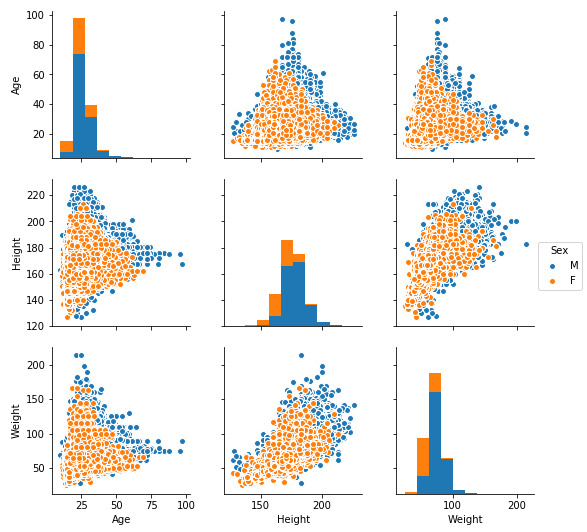

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(clean, hue="Sex")
plt.show()

Clearly the height and weight variables are correlated. Age is also somehow correlated although it is probably more relevant when it comes to the type of sport. There are obvious body metric differences between males and females. 

#### Handle categorical features
Convert Sex, Season to categorical using Integer Enccoding - although there is no ordinal relationship between this variables, they represent a binary class and a column of 1 and 0 should be good enough

Convert Sport and Country using one-hot encoding, this resulst in quite a sparse dataset with 269 features!

In [56]:
from sklearn.preprocessing import LabelEncoder # makes numbers 0,1,2,3 in one column
labelencoder = LabelEncoder()
clean['Sex_cat'] = labelencoder.fit_transform(clean.Sex) # Male is 1, Female is 0
clean['Season_cat'] = labelencoder.fit_transform(clean.Season) # Summer is 0, Winter is 1

In [57]:
one_hot_sport = pd.get_dummies(clean['Sport']) # 56 categories
one_hot_country = pd.get_dummies(clean['Country']) # 208 categories 

In [60]:
clean.drop(['Sex','Season','Sport','Country'],axis=1,inplace=True)

In [61]:
data = pd.concat([clean,one_hot_sport,one_hot_country],axis=1)

In [63]:
assert (data.shape[1] == 269)

# Findings 

Evaluation metric: Precision or Recall?

If it is more important to capture all the potential medal winners, while allowing for some false positives, then a simple decision tree does the best that can be done. This achieves a recall score of 0.43 at the expense of precision, which is low at 0.46. This model helps identify 43% of all medalist. Given relatively rudimentary features and a classification task with imbalanced classes, this is still better than always predicting the majority class. RandomForests and GradientBoostedDT don't achieve better results, just take more time. Hyperparameters tuning also didn't help.

If precision were to be given more importance, then a simple MLP neural net with one layer of 100 units achieves 0.66 precision but recall drops to 0.24, the overall F1 score is also below the Decision Tree.

Avenues for improvement? 
Add more features! Consider country specific features such as: GDP, population, human development index... and that is for starters. 

### Decision Tree

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data, y, random_state = 0)
DT = DecisionTreeClassifier().fit(X_train, y_train)
clf = DT.fit(X_train, y_train)

y_hat =clf.predict(X_test)
print(classification_report(y_test,y_hat))

             precision    recall  f1-score   support

        0.0       0.91      0.91      0.91     56316
        1.0       0.46      0.43      0.44      9398

avg / total       0.84      0.85      0.84     65714



In [65]:
confusion_matrix(y_test, y_hat)

array([[51511,  4805],
       [ 5365,  4033]])

In [50]:
# look at learned feature importances 
fr3 = pd.DataFrame(clf.feature_importances_,index=data.columns)
fr3 = fr3[0].sort_values(ascending=False)
fr3[:15]

Age           0.223807
Weight        0.215041
Height        0.211946
Sex_cat       0.024012
USA           0.017612
Russia        0.017156
Swimming      0.013541
Basketball    0.011695
Canada        0.008523
Germany       0.008368
Water Polo    0.008083
Fencing       0.007905
Rowing        0.006885
Gymnastics    0.006783
Football      0.006495
Name: 0, dtype: float64

### Try an NN

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nnclf = MLPClassifier(hidden_layer_sizes = [100], solver='lbfgs', activation ='relu', alpha = 1,
                         random_state = 0).fit(X_train_scaled, y_train)

clf = nnclf.fit(X_train_scaled, y_train)
y_hat = clf.predict(X_test_scaled)
print(classification_report(y_test,y_hat))

             precision    recall  f1-score   support

        0.0       0.89      0.98      0.93     56316
        1.0       0.65      0.24      0.35      9398

avg / total       0.85      0.87      0.85     65714



In [51]:
confusion_matrix(y_test, y_hat)

array([[55100,  1216],
       [ 7149,  2249]])